In [2]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import mdtraj as md
import numpy as np
import os

import MDAnalysis as mda
import nglview as nv

import pandas as pd

import gmxapi as gmx

import glob
from scipy import stats

In [3]:
from manuscript import *

<Figure size 432x288 with 0 Axes>

In [4]:
sns.set(style="ticks",context='paper',font_scale=2.5)

# Prepare antiparallel bi-bilayer system from equlibrated system

## Load single protein System

In [5]:
location = '../trajectory/PNU_EPJ/EPHYS/'

In [81]:
# Load equilibrated system.
u = mda.Universe(location + '../ca.pdb')

In [7]:
nv.show_mdanalysis(u)

NGLWidget()

## Generate rotated Protein System

In [82]:
x, y, z, _, _, _ = u.trajectory.ts.dimensions / 10

In [83]:
gmx_run = gmx.commandline_operation('gmx',
                  #  add tiny space along z between two box
                  arguments=['editconf', '-rotate', '180', '0', '0','-translate', '0', str(-y), '0.08'],
                  input_files={
                        '-f': location + 'ca.pdb'
                  },
                  output_files={
                        '-o': location + 'ca_rot.pdb'
                  }
                 )
gmx_run.run()
print(gmx_run.output.erroroutput.result())

In [24]:
gmx_run = gmx.commandline_operation('gmx',
                  arguments=['make_ndx', '-twin'],
                  input_files={
                        '-n': location + 'index.ndx'
                  },
                  output_files={
                        '-o': location + 'new_index.ndx'
                  },
                  stdin='q\n'
                 )
gmx_run.run()
print(gmx_run.output.erroroutput.result())

## Merge two Boxes

In [85]:
u_rot = mda.Universe(location + 'ca_rot.pdb')

u_merge = mda.Merge(u.atoms, u_rot.atoms)

u_merge.trajectory.ts.dimensions = u.trajectory.ts.dimensions

u_merge.trajectory.ts.dimensions[2] = u_merge.trajectory.ts.dimensions[2] * 2 + 0.8

u_merge.atoms.write(location + 'ca_merged.pdb')

In [ ]:
nv.show_mdanalysis(u_merge)

## Make index For new system

In [25]:
with mda.selections.gromacs.SelectionWriter(location + 'new_index.ndx', mode='a') as ndx:
    ndx.write(u_merge.atoms, name='SYSTEM')
    ndx.write(u_merge.select_atoms('resname SOD'), name='SOD')
    ndx.write(u_merge.select_atoms('resname CLA'), name='CLA')
    ndx.write(u_merge.select_atoms('resname CAM'), name='CAM')
    ndx.write(u_merge.select_atoms('resname TIP3'), name='SOL')
    ndx.write(u_merge.select_atoms('resname TIP3 CAM CLA SOD'), name='SOL_ION')

    ndx.write(u_merge.select_atoms('resid 247 and name CA and index 0:' +
                     str(int(u_merge.atoms.n_atoms/2))),
              name='resid_247_group0')
    ndx.write(u_merge.select_atoms('resid 247 and name CA and index ' + 
                     str(int(u_merge.atoms.n_atoms/2)) + ':' +
                     str(int(u_merge.atoms.n_atoms))),
              name='resid_247_group1')

## Write topology

In [93]:
shutil.copy(location+'../topol.top', location + '../topol_ephys.top')

'../trajectory/EPJ_PNU/EPHYS/../topol_ephys.top'

In [94]:
with open(location + '../topol_ephys.top',mode='r') as f:
    copy_line = False
    copy_list = []
    
    line = f.readline()
    while line:
        if line.find('Compound') >= 0:
            copy_line = True
        if copy_line:
            copy_list.append(line)
        line = f.readline()

with open(location + '../topol_ephys.top',mode='a') as f:
    f.writelines(copy_list)

## EM

In [96]:
gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': location + '../mdp/em.mdp',
                        '-c': location + 'ca_merged.pdb',
                        '-r': location + 'ca_merged.pdb',
                        '-p': location + '../topol_ephys.top',

                  },
                  output_files={
                        '-o': location + 'em.tpr'
                  }
                 )
gmx_run.run()
print(gmx_run.output.erroroutput.result())

In [97]:
gmx_run = gmx.commandline_operation('gmx',
                  arguments=['mdrun'],
                  input_files={
                        '-s': location + '/em.tpr',
                  },
                  output_files={
                        '-c': location + '/em.gro'
                  }
                 )
gmx_run.run()
print(gmx_run.output.erroroutput.result())

In [98]:
u_merge.load_new(location + 'em.gro')

<Universe with 631874 atoms>

In [8]:
gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': location + '../mdp/ca.mdp',
                        '-c': location + 'em.gro',
                        '-r': location + 'em.gro',
                        '-p': location + '../topol_ephys.top',

                  },
                  output_files={
                        '-o': location + 'ca_eq.tpr'
                  }
                 )
gmx_run.run()
print(gmx_run.output.erroroutput.result())

In [ ]:
#  Run extra equilibration to generate `ca_eq.gro`

## Generate Production TPR

In [15]:
list_imbalance = ['12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32','34']

In [16]:
for imbalance in list_imbalance:
    im = eval(imbalance)
    total_ion = 484
    ion_in_a = int((total_ion + im) / 2)
    ion_in_b = int((total_ion - im) / 2)
    sed_inplace(location + 'ephys_mdp/ephys_temp.mdp',
                r'IONINA',
                str(ion_in_a),
                dest=location + 'ephys_mdp/ephys_' + imbalance + '.mdp')

    sed_inplace(location + 'ephys_mdp/ephys_' + imbalance + '.mdp',
                r'IONINB',
                str(ion_in_b))

In [42]:
for charge_imbalance in list_imbalance:
    try:
        os.mkdir(location + 'ephys_' + charge_imbalance)
    except:
        pass
    gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': location + 'ephys_mdp/ephys_' + charge_imbalance + '.mdp',
                        '-c': location + 'ca_eq.pdb',
                        '-r': location + 'ca_eq.pdb',
                        '-p': location + '../topol_ephys.top',
                        '-n': location + 'new_index.ndx'
                  },
                  output_files={
                        '-o': location + 'ephys_' + charge_imbalance + '/ephys.tpr'
                  }
                 )
    gmx_run.run()
    print(gmx_run.output.erroroutput.result())

In [ ]:
#  create double precision tpr files for analysis

for charge_imbalance in list_imbalance:
#    os.mkdir(location + 'ephys_' + charge_imbalance)
    gmx_run = gmx.commandline_operation('gmx_d',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': location + 'ephys_mdp/ephys_' + charge_imbalance + '.mdp',
                        '-c': location + 'ca_eq.gro',
                        '-r': location + 'ca_eq.gro',
                        '-p': location + '../topol_ephys.top',
                        '-n': location + 'new_index.ndx'
                  },
                  output_files={
                        '-o': location + 'ephys_' + charge_imbalance + '/ephys_double.tpr'
                  }
                 )
    gmx_run.run()
    print(gmx_run.output.erroroutput.result())

## Voilà!

# Analysis

In [6]:
from NACHRA7_annotations import *

In [7]:
traj_note_dic = comp_ephys_dic

In [8]:
traj_note_dic

{'traj_note': ['BGT', 'PNU_EPJ', 'EPJ'],
 'imbalance': [12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34],
 'dir': 'EPHYS',
 'save_location': ['../trajectory/BGT',
  '../trajectory/PNU_EPJ',
  '../trajectory/EPJ']}

In [9]:
class POTENTIAL_XVG(object):
    def __init__(self, location):
        self.filename = location
        self.read()
        
    def read(self):
        self.potential = pd.read_table(self.filename,
                                 header=None,
                                 names=['coord','potential'],
                                 sep='\s+',
                                 error_bad_lines=False,
                                 skiprows=24)
        for column in self.potential:
            self.potential[column] = self.potential[column].astype(float)       
#        self.potential['potential'] = self.potential['potential']

In [10]:
class EPHYS_XVG(object):
    def __init__(self, location):
        self.filename = location

        self.read()
        
    def read(self):
        self.permeation_ion = []
        self.permeation_channel = []

        self.ephys = pd.read_table(self.filename,
                                 header=None,
                                 names=['time','s0', 's1', 's2', 's3', 's4', 's5', 's6', 's7','s8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17','s18'],
                                 sep='\s+',
                                 error_bad_lines=False,
                                 skiprows=62,
                                 skipfooter=1)

        self.ephys = self.ephys[self.ephys.time != '#']
        self.ephys = self.ephys[self.ephys.time != '@']
        
        for column in self.ephys:
            self.ephys[column] = self.ephys[column].astype(float)
            
        permeation_lines = []
        with open(self.filename) as f:
            for line in f:
                if '# Atom nr.' in line:
                    permeation_lines.append(line)
        for line in permeation_lines:
            self.permeation_ion.append(int(line.split(' ')[3])-1)
            self.permeation_channel.append(int(line.split(' ')[-1][-3]))
        self.ephys['time'] = self.ephys['time']/1000

In [11]:
def create_md_dataframe():    
    return pd.DataFrame(columns=list(['MD_name','imbalance','traj_time','system','ligand','note']))

In [201]:
def append_metadata(traj_note, imbalance, system, location):
        rep_data = []
        traj_note_split = traj_note.split('_')
        try:
            top_location = '/EPHYS/ephys_' + str(imbalance) + '/ephys.tpr'
            traj_location = '/EPHYS/ephys_' + str(imbalance) + '/ephys.xtc'
            traj = mda.Universe(location + top_location,
                                location + traj_location)         
            md_name = traj_note_split[0]
            ligand = traj_note_split[1:-1] ##in this case
            note = traj_note_split[-1]
            n_frames = traj.trajectory.n_frames
            ts = traj.trajectory.dt
            rep_data.append([md_name, imbalance, n_frames * ts, system, ligand, note])

        except:
            print(traj_note + ' not found.')
        return rep_data
    
    
meta_data = Parallel(n_jobs=num_cores)(delayed(append_metadata)(traj_note = traj_note, 
                                                        imbalance = imbalance,
                                                        system = ind,
                                                        location = traj_note_dic['save_location'][ind])
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           for imbalance in traj_note_dic['imbalance']
                           )
xvg_data = create_md_dataframe()
for i in range(0, len(meta_data)):
    xvg_data = xvg_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','imbalance','traj_time','system','ligand','note'])),ignore_index=True)
xvg_data['traj_time'] = xvg_data['traj_time'].apply(float)
xvg_data['imbalance'] = xvg_data['imbalance'].apply(int)
xvg_data['system'] = xvg_data['system'].apply(int)

In [202]:
def get_potential_correct(location, charge_imbalance):
    gmx_run = gmx.commandline_operation('gmx_d',
                      arguments=['potential','-sl','5000','-correct', '-tz', '-18.72'],
                      input_files={
                            '-f': location + '/EPHYS/ephys_' + charge_imbalance + '/ephys.xtc',
                            '-s': location + '/EPHYS/ephys_' + charge_imbalance + '/ephys_double.tpr',
                            '-n': location + '/EPHYS/new_index.ndx'
                      },
                      output_files={
                            '-o': location + '/EPHYS/ephys_' + charge_imbalance + '/potential_correct.xvg',
                            '-oc': location + '/EPHYS/ephys_' + charge_imbalance + '/charge_correct.xvg',
                            '-of': location + '/EPHYS/ephys_' + charge_imbalance + '/field_correct.xvg'


                      },
                      stdin='4\n'
                     )
    gmx_run.run()
    print(gmx_run.output.erroroutput.result())

    try:
        for f in glob.glob(location + '/EPHYS/ephys_' + str(charge_imbalance) + '/#*'):
            os.remove(f)
    except:
        pass
    
def append_potential_correct(traj_note, imbalance, system, location):
    potential_data = []
    try:
        get_potential_correct(location, str(imbalance))
        potential_data.append(POTENTIAL_XVG(location + '/EPHYS/ephys_' + str(imbalance) + '/potential_correct.xvg'))

    except:
        pass
    return potential_data
    
potention_data = Parallel(n_jobs=num_cores)(delayed(append_potential_correct)(traj_note = traj_note, 
                                                        imbalance = imbalance,
                                                        system = ind,
                                                        location = traj_note_dic['save_location'][ind])
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           for imbalance in traj_note_dic['imbalance']
                           )    
xvg_data['potential_correct'] = [x for x in np.hstack(potention_data) if x is not None]

In [128]:
def append_ephys(traj_note, imbalance, system, location):
    ephys_data = []
    try:
        ephys_data.append(EPHYS_XVG(location + '/EPHYS/ephys_' + str(imbalance) + '/ephys.xvg'))

    except:
        pass
    return ephys_data
    
ephys_data = Parallel(n_jobs=num_cores)(delayed(append_ephys)(traj_note = traj_note, 
                                                        imbalance = imbalance,
                                                        system = ind,
                                                        location = traj_note_dic['save_location'][ind])
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           for imbalance in traj_note_dic['imbalance']
                           )    
xvg_data['ephys_xvg'] = [x for x in np.hstack(ephys_data) if x is not None]

In [129]:
xvg_data.to_pickle('ephys_xvg.pickle')

In [12]:
xvg_data = pd.read_pickle('./data/ephys_xvg.pickle')

In [13]:
xvg_data

,MD_name,imbalance,traj_time,system,ligand,note,potential_correct,ephys_xvg
0,NACHRA7,12,132400.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd151818e0>,<__main__.EPHYS_XVG object at 0x7fbd0dc92910>
1,NACHRA7,14,131720.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15181f10>,<__main__.EPHYS_XVG object at 0x7fbd0dc9a1f0>
2,NACHRA7,16,131720.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15157b20>,<__main__.EPHYS_XVG object at 0x7fbd0dca60a0>
3,NACHRA7,18,132520.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15157400>,<__main__.EPHYS_XVG object at 0x7fbd0dca6f10>
4,NACHRA7,20,133240.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15157be0>,<__main__.EPHYS_XVG object at 0x7fbd0dc327c0>
5,NACHRA7,22,133040.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd582f1cd0>,<__main__.EPHYS_XVG object at 0x7fbd0dc3d070>
6,NACHRA7,24,132600.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15111340>,<__main__.EPHYS_XVG object at 0x7fbd0dc3dee0>
7,NACHRA7,26,133080.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15111610>,<__main__.EPHYS_XVG object at 0x7fbd0dc49790>
8,NACHRA7,28,138640.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd151119d0>,<__main__.EPHYS_XVG object at 0x7fbd0dc54040>
9,NACHRA7,30,138200.0,1,"[NOPNU, EPJ]",POPC,<__main__.POTENTIAL_XVG object at 0x7fbd15111d90>,<__main__.EPHYS_XVG object at 0x7fbd0dc548b0>


In [14]:
legend_dic = {'s0':"A NA_NA_copy ions (charge +1)",
               's1':"A av. mismatch to 130 NA_NA_copy ions",
's2':"A net NA_NA_copy ion influx",
's3':"A CL_CL_copy ions (charge -1)",
's4':"A av. mismatch to 113 CL_CL_copy ions",
's5':"A net CL_CL_copy ion influx",
's6':"B NA_NA_copy ions (charge +1)",
's7': "B av. mismatch to 132 NA_NA_copy ions",
's8': "B net NA_NA_copy ion influx",
's9': "B CL_CL_copy ions (charge -1)",
's10': "B av. mismatch to 113 CL_CL_copy ions",
's11': "B net CL_CL_copy ion influx",
's12': "Z-center of geometry of split group 0",
's13': "Z-center of geometry of split group 1",
's14': "A->ch0->B NA_NA_copy permeations",
's15': "A->ch0->B CL_CL_copy permeations",
's16': "A->ch1->B NA_NA_copy permeations",
's17': "A->ch1->B CL_CL_copy permeations",
's18': "leakage"}

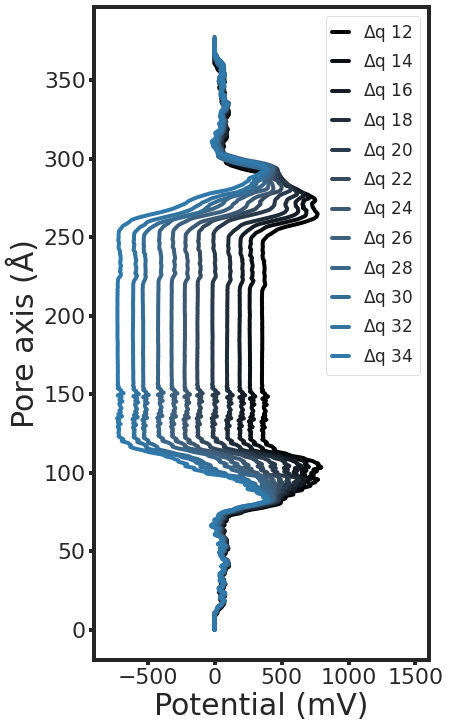

In [22]:
fig, ax = plt.subplots(figsize=(6,12))

for ind, row in xvg_data.iterrows():
    data = row['potential_correct'].potential
    ax.plot(data['potential'] * 1000,
            data['coord']*10,

            linewidth=4,
            color=cmap_open(ind * int(cmap_open.N / xvg_data.shape[0])),
            label=r'$\Delta$q ' + str(row['imbalance']),
            )
ax.legend(loc=1,handlelength=1,fontsize=17)
ax.set_xlabel('Potential (mV)',fontsize=30)
ax.set_ylabel('Pore axis (Å)',fontsize=30)

set_axis_boarder(ax)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.15)
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.set_xlim(-900,1600)
#plt.setp(ax.get_xticklabels(), visible=False)
    
plt.savefig('Figures/figure2_a.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

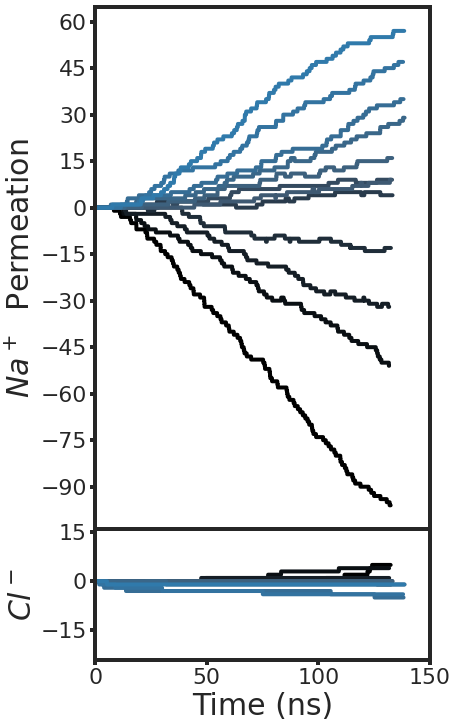

In [31]:
fig, axes = plt.subplots(2,1, figsize=(6,12), gridspec_kw={'height_ratios': [4, 1]})

for ind, row in xvg_data.iterrows():
    data = row['ephys_xvg'].ephys
    axes[0].plot(
            data['time'],
            data['s14'] + data['s16'],
            linewidth=4,
            color=cmap_open(ind * int(cmap_open.N / xvg_data.shape[0])))
    axes[1].plot(
            data['time'],            

            data['s15'] + data['s17'],
            linewidth=4,
            color=cmap_open(ind * int(cmap_open.N / xvg_data.shape[0])))
    
#axes[0].legend([r'$Na^+$ Permeation'],loc=3)
axes[0].set_xlabel('Time (ns)',fontsize=30)
axes[0].set_xlim(0,150)
axes[1].set_xlim(0,150)
axes[1].set_ylim(-100,64)
axes[0].yaxis.set_major_locator(MultipleLocator(15))

axes[0].set_ylabel(r'$Na^+$  Permeation',fontsize=30)
    
#axes[1].legend([r'$Cl^-$ Permeation'],loc=3)

axes[1].set_xlabel('Time (ns)',fontsize=30)
axes[1].set_ylabel(r'$Cl^-$',fontsize=30)
axes[1].set_ylim(-24,16)
axes[1].yaxis.set_major_locator(MultipleLocator(15))

for ax in axes:
    set_axis_boarder(ax)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.15)
plt.setp(axes[0].get_xticklabels(), visible=False)

    
plt.savefig('Figures/figure2_b.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

## Conductance Calculation

Conductance calculations $$G = I/dU$$ were based on ion current I as a function
of the potential difference DU between the compartments. To obtain an error
estimate, and because potential and flux are time-dependent, $dU(t)$ and $I(t)$
were determined within 20-ns time windows, with 10-ns overlap among
consecutive slices.

In [133]:
def create_md_dataframe():    
    return pd.DataFrame(columns=list(['MD_name','imbalance','start_time', 'end_time','system','ligand','note']))

In [134]:
def append_metadata(traj_note, imbalance, system, location):
        rep_data = []
        traj_note_split = traj_note.split('_')
        try:
            top_location = '/EPHYS/ephys_' + str(imbalance) + '/ephys.tpr'
            traj_location = '/EPHYS/ephys_' + str(imbalance) + '/ephys.xtc'
            traj = mda.Universe(location + top_location,
                                location + traj_location)         
            md_name = traj_note_split[0]
            ligand = traj_note_split[1:-1] ##in this case
            note = traj_note_split[-1]
            n_frames = traj.trajectory.n_frames
            ts = traj.trajectory.dt
            time_window = np.arange(0, ts * n_frames, 10000)
            start_time = time_window
            end_time = time_window + 20000
            for st, et in zip(start_time,end_time):
                rep_data.append([md_name, imbalance, st, et, system, ligand, note])

        except:
            print(traj_note + ' not found.')
        return rep_data
    
    
meta_data = Parallel(n_jobs=num_cores)(delayed(append_metadata)(traj_note = traj_note, 
                                                        imbalance = imbalance,
                                                        system = ind,
                                                        location = traj_note_dic['save_location'][ind])
                           for ind, traj_note in enumerate(traj_note_dic['traj_note'])
                           for imbalance in traj_note_dic['imbalance']
                           )
conduct_data = create_md_dataframe()
for i in range(0, len(meta_data)):
    conduct_data = conduct_data.append(pd.DataFrame(meta_data[i],columns=list(['MD_name','imbalance','start_time','end_time','system','ligand','note'])),ignore_index=True)
conduct_data['start_time'] = conduct_data['start_time'].apply(int)
conduct_data['end_time'] = conduct_data['end_time'].apply(int)
conduct_data['imbalance'] = conduct_data['imbalance'].apply(int)
conduct_data['system'] = conduct_data['system'].apply(int)

In [135]:
def get_potential_window(location, charge_imbalance, st, et):
    loc = location + '/EPHYS/ephys_' + str(charge_imbalance) + '/'
    gmx_run = gmx.commandline_operation('gmx_d',
                            arguments=['potential','-sl','5000','-correct', '-tz', '-18.72', '-b', str(st), '-e', str(et)],
                      input_files={
                            '-f': loc + 'ephys.xtc',
                            '-s': loc + 'ephys_double.tpr',
                            '-n': location + '/EPHYS/new_index.ndx'
                      },
                      output_files={
                            '-o': loc + 'raw_data/' + str(st) + '_' + str(et) + '_potential.xvg',
                            '-oc': loc + 'raw_data/' + str(st) + '_' + str(et) + '_charge.xvg',
                            '-of': loc + 'raw_data/' + str(st) + '_' + str(et) + '_field.xvg'
                      },
                      stdin='4\n'
                     )
    gmx_run.run()
    print(gmx_run.output.erroroutput.result())
    
    try:
        for f in glob.glob(location + '/EPHYS/ephys_' + str(charge_imbalance) + '/raw_data/#*'):
            os.remove(f)
    except:
        pass
    
def append_potential_window(ind, row):
    potential_data = []
    location = traj_note_dic['save_location'][row.system]
    imbalance = row.imbalance
    try:
        os.mkdir(location + '/EPHYS/ephys_' + str(imbalance) + '/raw_data')
    except:
        print('fail mkdir')
        
    get_potential_window(location, str(imbalance), row.start_time, row.end_time)
    try:
        potential_data.append(POTENTIAL_XVG(location + '/EPHYS/ephys_' + str(imbalance) + '/raw_data/' + str(row.start_time) + '_' + str(row.end_time) + '_potential.xvg'))
    except:
        print('get potential fail')
    return potential_data
    
potention_data = Parallel(n_jobs=num_cores)(delayed(append_potential_window)(ind, row)
                           for ind, row in conduct_data.iterrows())
conduct_data['potential_data'] = [x for x in np.hstack(potention_data) if x is not None]

In [136]:
conduct_data['potential'] = conduct_data['potential_data'].apply(lambda x: x.potential.potential[2500]) - \
                            conduct_data['potential_data'].apply(lambda x: x.potential.potential[0])

In [137]:
legend_dic = {'s0':"A NA_NA_copy ions (charge +1)",
               's1':"A av. mismatch to 130 NA_NA_copy ions",
's2':"A net NA_NA_copy ion influx",
's3':"A CL_CL_copy ions (charge -1)",
's4':"A av. mismatch to 113 CL_CL_copy ions",
's5':"A net CL_CL_copy ion influx",
's6':"B NA_NA_copy ions (charge +1)",
's7': "B av. mismatch to 132 NA_NA_copy ions",
's8': "B net NA_NA_copy ion influx",
's9': "B CL_CL_copy ions (charge -1)",
's10': "B av. mismatch to 113 CL_CL_copy ions",
's11': "B net CL_CL_copy ion influx",
's12': "Z-center of geometry of split group 0",
's13': "Z-center of geometry of split group 1",
's14': "A->ch0->B NA_NA_copy permeations",
's15': "A->ch0->B CL_CL_copy permeations",
's16': "A->ch1->B NA_NA_copy permeations",
's17': "A->ch1->B CL_CL_copy permeations",
's18': "leakage"}

In [138]:
def append_current_window(ind, row):
    current_data = []
    columb_e_conv = 6.242E18
    ephys_xvg = xvg_data.loc[(xvg_data.imbalance == row.imbalance) & (xvg_data.system == row.system), 'ephys_xvg']
    ephys_dat = ephys_xvg.values[0].ephys
    ephys_xvg_window = ephys_dat[(ephys_dat.time <= row.end_time / 1000) & (ephys_dat.time >= row.start_time / 1000)]
    accum_ion_ch0_sod = ephys_xvg_window['s14'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s14'][ephys_xvg_window.index[0]]
    accum_ion_ch0_cla = ephys_xvg_window['s15'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s15'][ephys_xvg_window.index[0]]
    accum_ion_ch1_sod = ephys_xvg_window['s16'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s16'][ephys_xvg_window.index[0]]
    accum_ion_ch1_cla = ephys_xvg_window['s17'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s17'][ephys_xvg_window.index[0]]
    
    time_window = ephys_xvg_window['time'][ephys_xvg_window.index[-1]] - ephys_xvg_window['time'][ephys_xvg_window.index[0]]
    accum_ion = accum_ion_ch0_sod + accum_ion_ch1_sod - \
                accum_ion_ch0_cla - accum_ion_ch1_cla

    current_data.append(accum_ion / columb_e_conv / time_window / 1E-12  * 1E6)
    return current_data
            
current_data = []
for ind, row in conduct_data.iterrows():
    current_data.append(append_current_window(ind, row))

conduct_data['current'] = [x for x in np.hstack(current_data) if x is not None]

In [139]:
def append_current_window(ind, row):
    current_data = []
    columb_e_conv = 6.242E18
    ephys_xvg = xvg_data.loc[(xvg_data.imbalance == row.imbalance) & (xvg_data.system == row.system), 'ephys_xvg']
    ephys_dat = ephys_xvg.values[0].ephys
    ephys_xvg_window = ephys_dat[(ephys_dat.time <= row.end_time / 1000) & (ephys_dat.time >= row.start_time / 1000)]
    
    accum_ion_ch0_sod = ephys_xvg_window['s14'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s14'][ephys_xvg_window.index[0]]
    accum_ion_ch0_cla = ephys_xvg_window['s15'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s15'][ephys_xvg_window.index[0]]
    accum_ion_ch1_sod = ephys_xvg_window['s16'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s16'][ephys_xvg_window.index[0]]
    accum_ion_ch1_cla = ephys_xvg_window['s17'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s17'][ephys_xvg_window.index[0]]
    
    time_window = ephys_xvg_window['time'][ephys_xvg_window.index[-1]] - ephys_xvg_window['time'][ephys_xvg_window.index[0]]
    accum_ion = accum_ion_ch0_sod + accum_ion_ch1_sod

    current_data.append(accum_ion / columb_e_conv / time_window / 1E-12 * 1E6)
    return current_data
            
current_data = []
for ind, row in conduct_data.iterrows():
    current_data.append(append_current_window(ind, row))

conduct_data['current_sod'] = [x for x in np.hstack(current_data) if x is not None]

In [140]:
def append_current_window(ind, row):
    current_data = []
    columb_e_conv = 6.242E18
    ephys_xvg = xvg_data.loc[(xvg_data.imbalance == row.imbalance) & (xvg_data.system == row.system), 'ephys_xvg']
    ephys_dat = ephys_xvg.values[0].ephys
    ephys_xvg_window = ephys_dat[(ephys_dat.time <= row.end_time / 1000) & (ephys_dat.time >= row.start_time / 1000)]
    
    accum_ion_ch0_sod = ephys_xvg_window['s14'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s14'][ephys_xvg_window.index[0]]
    accum_ion_ch0_cla = ephys_xvg_window['s15'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s15'][ephys_xvg_window.index[0]]
    accum_ion_ch1_sod = ephys_xvg_window['s16'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s16'][ephys_xvg_window.index[0]]
    accum_ion_ch1_cla = ephys_xvg_window['s17'][ephys_xvg_window.index[-2]] - ephys_xvg_window['s17'][ephys_xvg_window.index[0]]
    
    time_window = ephys_xvg_window['time'][ephys_xvg_window.index[-1]] - ephys_xvg_window['time'][ephys_xvg_window.index[0]]
    accum_ion = accum_ion_ch0_cla + accum_ion_ch1_cla

    current_data.append(-accum_ion / columb_e_conv / time_window / 1E-12  * 1E6)
    return current_data
            
current_data = []
for ind, row in conduct_data.iterrows():
    current_data.append(append_current_window(ind, row))

conduct_data['current_cla'] = [x for x in np.hstack(current_data) if x is not None]

In [141]:
conduct_data.to_pickle('data/ephys_conduct.pickle')

In [13]:
#conduct_data = pd.read_pickle('data/ephys_conduct.pickle')

In [14]:
conduct_data = conduct_data[conduct_data.start_time > 50000]
conduct_data['potential'] = conduct_data['potential'] * 1000
conduct_data['current'] = conduct_data['current'] * 1000 / 2

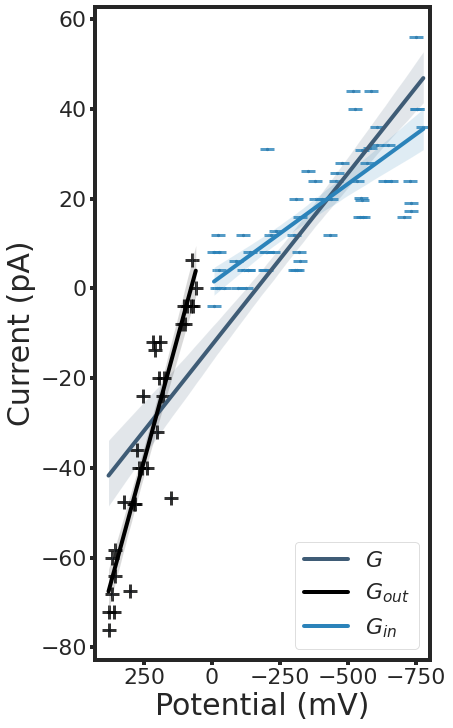

In [15]:
fig, ax = plt.subplots(figsize=(6,12))

slope, intercept, r_value, p_value, std_err = stats.linregress(conduct_data['potential'],conduct_data['current'])
new_line_kws = {'label': r"$G$"}
new_line_kws.update(line_kws)

sns.regplot(data=conduct_data,
            x='potential',
            y='current',line_kws=new_line_kws,
            ax=ax,color='#3F5C76', marker='.', scatter_kws={'s':20})



linear_conduct_data = conduct_data[conduct_data.potential >= 0]
slope, intercept, r_value, p_value, std_err = stats.linregress(linear_conduct_data['potential'],linear_conduct_data['current'])

new_line_kws = {'label': r"$G_{{out}}$"}

new_line_kws.update(line_kws)
sns.regplot(data=linear_conduct_data,
            x='potential',
            y='current',line_kws=new_line_kws,
            ax=ax, color='#000000',marker='+', scatter_kws=scatter_kws)

linear_conduct_data = conduct_data[conduct_data.potential <= 0]
slope, intercept, r_value, p_value, std_err = stats.linregress(linear_conduct_data['potential'],linear_conduct_data['current'])
new_line_kws = {'label': r"$G_{{in}}$"}

new_line_kws.update(line_kws)
sns.regplot(data=linear_conduct_data,
            x='potential',
            y='current',line_kws=new_line_kws,
            ax=ax,color='#2B83BA',marker="_", scatter_kws={'s':200,'linewidths':3}, )

ax.legend(loc=4)

ax.set_xlabel('Potential (mV)',fontsize=30)
ax.set_ylabel('Current (pA)',fontsize=30)

ax.set_xlim(-800,430)
ax.set_xlim(ax.get_xlim()[::-1])
set_axis_boarder(ax)
plt.savefig('Figures/Conductance_0CA.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)